# Analyse van de data - Cognitie en Perceptie
Moad Matoug, Luca van Kessel, Thom Varela Nunes, Bart van der Lee, Arman Aghsami

## Imports

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import re
from scipy.stats import pearsonr

## Openen en opschonen data

#### We beginnen met het importeren en opschonen van de data die we als eerste hebben verzameld

In [2]:
# Importeer de data
alle_data = pd.read_csv("data2024.csv")


# Print de shape van alle_data
print('Shape van alle data:', alle_data.shape, '\n')


# Verkort de ellendige lange kolomnamen
alle_data.columns = [col.split(':')[0] for col in alle_data.columns]


# Pak alle relevante data (namelijk alle resultaten van de SART tests en de survey data over sport)
data = alle_data[['Q4', 'Q13_1', 'Q13_2', 'Q13_4', 'Q13_5', 'Q41', 'Q42', 'Q43', 'Q44']]

# Verander de kolomnamen naar iets leesbaarders
data.columns = ['geslacht', 'amount_go', 'go_mistakes', 'amount_no_go', 'no_go_mistakes', 'sport_uur_week', 'sport_frequentie', 'soort_sport', 'sport_sessie_duur']
data['studie'] = 'informatiekunde'

print(data.geslacht.unique())
# We maken van sport_uur_week een numerieke waarde
sport_data = list()

for value in data['sport_uur_week']:
    regex_match = re.search("\d", value)

    if isinstance(regex_match, type(None)):
        sport_data.append(np.nan)
            
    else:
        sport_data.append(int(regex_match.group(0)))

data['sport_uur_week'] = sport_data


# Er zitten NaN waarden in de data. Hier kunnen we niks mee en dus moeten we deze rijen verwijderen
data = data.dropna(subset=['amount_go', 'go_mistakes', 'amount_no_go', 'no_go_mistakes', 'sport_uur_week', 'sport_frequentie', 'sport_sessie_duur'])


# Vervolgens gaan we de categorische data omzetten naar numerieke waarden
data['sport_frequentie'] = data['sport_frequentie'].map({'Nooit': 0, '1-2 keer': 1, '3-4 keer': 2, '5 keer of meer': 3})
data['sport_sessie_duur'] = data['sport_sessie_duur'].map({'Minder dan 30 minuten': 0, '30-60 minuten': 1, '1-2 uur' : 2, 'Meer dan 2 uur': 3})


# Print de eerste vijf rijen van de data en de shape
print('Eerste vijf rijen van de opgeschoonde data:')
display(data.head())
print('Shape van de opgeschoonde data:', data.shape)

Shape van alle data: (82, 86) 

['Man' 'Vrouw' 'Dat zeg ik liever niet']
Eerste vijf rijen van de opgeschoonde data:


,geslacht,amount_go,go_mistakes,amount_no_go,no_go_mistakes,sport_uur_week,sport_frequentie,soort_sport,sport_sessie_duur,studie
1,Man,16.0,0.0,2.0,2.0,2.0,1,fitness,1,informatiekunde
2,Man,16.0,1.0,3.0,3.0,8.0,3,"Rennen, voetballen, boksen",2,informatiekunde
3,Vrouw,16.0,0.0,2.0,0.0,3.0,3,fietsen,0,informatiekunde
4,Man,16.0,0.0,2.0,1.0,3.0,1,Voetbal,2,informatiekunde
5,Man,200.0,6.0,25.0,19.0,6.0,2,"Fitness, Kickboksen",2,informatiekunde


Shape van de opgeschoonde data: (79, 10)


#### Nu gaan we de extra data die we hebben verzameld importeren en opschonen

In [3]:
# Importeer de extra data
extra_data = pd.read_csv("extra_data.csv")

print(extra_data.columns)
# Print de shape van extra_data
print('Shape van alle extra data:', extra_data.shape, '\n')


# Verwijder de rijen van participanten die geen opleiding volgen; dit onderzoek kijkt immers naar Nederlandse studenten
extra_data = extra_data[extra_data["Wat voor studie volgt u momenteel? (Indien u geen studie volgt kunt u 'nvt' beantwoorden)"] != 'nvt']


# Pak de kolommen die we nodig hebben
extra_data = extra_data[['Wat is uw geslacht?','Number Go Trials', 'Number Go Mistakes', 'Number No Go Trials', 'Number No Go Mistakes',
                         'Hoe vaak per week doe je aan fysieke activiteit (minstens 30 minuten per sessie)?',
                         'Welke vorm van fysieke activiteit doe je meestal? (indien je meerdere sporten verricht benoem het als volgt: sport1,sport2...)',
                         'Hoe lang duurt een gemiddelde sessie van fysieke activiteit?', "Wat voor studie volgt u momenteel? (Indien u geen studie volgt kunt u 'nvt' beantwoorden)"]]


# Hernoem de kolommen naar namen die overeenkomen met de andere data
extra_data.columns = ['geslacht', 'amount_go', 'go_mistakes', 'amount_no_go', 'no_go_mistakes', 'sport_frequentie', 'soort_sport', 'sport_sessie_duur', 'studie']


# We maken van sport_frequentie een numerieke waarde
freq_data = list()

for value in extra_data['sport_frequentie']:
    regex_match = re.search("\d", value)

    if isinstance(regex_match, type(None)):
        freq_data.append(np.nan)
            
    else:
        freq_data.append(int(regex_match.group(0)))

extra_data['sport_frequentie'] = freq_data


# We maken van sport_sessie_duur een numerieke waarde
sessie_data = list()

for value in extra_data['sport_sessie_duur']:
    regex_match = re.search("\d", value)

    if isinstance(regex_match, type(None)):
        sessie_data.append(np.nan)
    
    elif regex_match.group(0) == '3':
        sessie_data.append(0.5)

    else:
        sessie_data.append(int(regex_match.group(0)))

extra_data['sport_sessie_duur'] = sessie_data


# Bereken het aantal uur dat iemand per week sport en sla dit op in de nieuwe kolom 'sport_uur_week'
extra_data['sport_uur_week'] = extra_data['sport_frequentie'] * extra_data['sport_sessie_duur']


# Rond de getallen af en maak er integers van (de + 0.1 is om te zorgen dat de getallen correct worden afgerond)
extra_data['sport_uur_week'] = (extra_data['sport_uur_week'] + 0.1).round().astype(int)


# Verander de volgorde van de kolommen om overeen te komen met de andere data
extra_data = extra_data[['geslacht', 'amount_go', 'go_mistakes', 'amount_no_go', 'no_go_mistakes', 'sport_uur_week', 'sport_frequentie', 'soort_sport', 'sport_sessie_duur', 'studie']]


# Er zitten NaN waarden in de data. Hier kunnen we niks mee en dus moeten we deze rijen verwijderen
extra_data = extra_data.dropna(subset=['amount_go', 'go_mistakes', 'amount_no_go', 'no_go_mistakes', 'sport_uur_week', 'sport_frequentie', 'sport_sessie_duur'])


# Print de shape van de opgeschoonde extra_data
print('Shape van de opgeschoonde extra data:', extra_data.shape, '\n')


# Print de eerste vijf rijen van de opgeschoonde extra_data
print('\nEerste vijf rijen van de opgeschoonde data:')
display(extra_data.head())

Index(['Tijdstempel', 'Wat is uw geslacht?', 'Wat is uw leeftijd?',
       'Wat voor studie volgt u momenteel? (Indien u geen studie volgt kunt u 'nvt' beantwoorden)',
       'Number Go Trials', 'Number Go Mistakes', 'Go Mistakes %',
       'Number No Go Trials', 'Number No Go Mistakes', 'No Go Mistakes %',
       'Welke vorm van fysieke activiteit doe je meestal? (indien je meerdere sporten verricht benoem het als volgt: sport1,sport2...)',
       'Hoe vaak per week doe je aan fysieke activiteit (minstens 30 minuten per sessie)?',
       'Hoe lang duurt een gemiddelde sessie van fysieke activiteit?'],
      dtype='object')
Shape van alle extra data: (20, 13) 

Shape van de opgeschoonde extra data: (17, 10) 


Eerste vijf rijen van de opgeschoonde data:


,geslacht,amount_go,go_mistakes,amount_no_go,no_go_mistakes,sport_uur_week,sport_frequentie,soort_sport,sport_sessie_duur,studie
0,Man,200.0,0.0,25.0,5.0,3,3,"Voetbal, gym",1.0,Informatiekunde
1,Man,200.0,0.0,25.0,7.0,3,5,"fitness,dans,fietsen,wandelen",0.5,WO Bachelor
4,Man,200.0,40.0,30.0,21.0,3,3,fitness,1.0,Bedrijfskunde
5,Man,200.0,8.0,25.0,23.0,3,3,sportschool,1.0,gezondheidswetenschappen
6,Man,16.0,0.0,2.0,1.0,3,5,Fitness,0.5,Informatiekunde


#### Als laatste gaan we de bruikbare data uit de eerste verzamelronde en de bruikbare data uit de tweede verzamelronde samenvoegen

In [4]:
'''
Gezien de data in de kolommen 'sport_frequentie' en 'sport_sessie_duur' van de extra data niet gelijkvormig zijn aan de eerst verzamelde data,
 zullen we deze kolommen verwijderen
'''
data = data.drop(columns=['sport_frequentie', 'sport_sessie_duur'])
extra_data = extra_data.drop(columns=['sport_frequentie', 'sport_sessie_duur'])


# Voeg de data samen
data = pd.concat([data, extra_data], ignore_index=True)


# Nu gaan we uit dit gecombineerde dataframe de onbruikbare data filteren
data = data[data['amount_go'] == 200]
data = data[data['amount_no_go'] == 25]


# Reset de index van de data
data = data.reset_index(drop=True)


# Print de shape van de samengevoegde data
print('Shape van de samengevoegde data:', data.shape, '\n')


# Print de eerste vijf rijen van de samengevoegde data
print('Eerste vijf rijen van de samengevoegde data:')
display(data.head())

Shape van de samengevoegde data: (35, 8) 

Eerste vijf rijen van de samengevoegde data:


,geslacht,amount_go,go_mistakes,amount_no_go,no_go_mistakes,sport_uur_week,soort_sport,studie
0,Man,200.0,6.0,25.0,19.0,6.0,"Fitness, Kickboksen",informatiekunde
1,Man,200.0,0.0,25.0,18.0,7.0,Sportschool,informatiekunde
2,Man,200.0,0.0,25.0,7.0,1.0,Karten,informatiekunde
3,Man,200.0,1.0,25.0,19.0,4.0,Fitness,informatiekunde
4,Vrouw,200.0,4.0,25.0,12.0,2.0,"Sportschool, fietsen, wandelen",informatiekunde


## Analyse

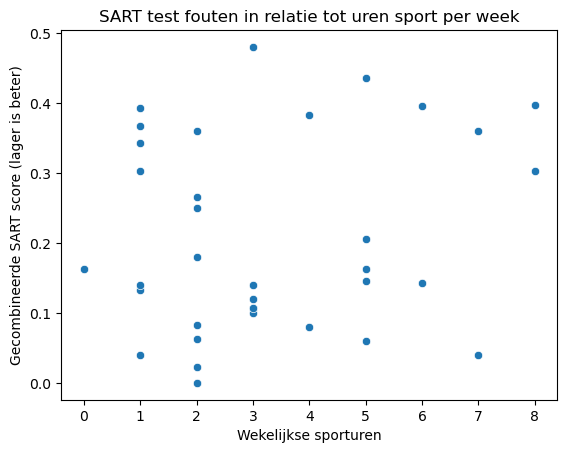


Een Pearson correlatie coëfficient van 0.17079421093224226 betekent dat er een zeer zwakke correlatie is tussen de sport uren en de SART score.
Een p-value van 0.32660824044425596 betekent dat er geen significant verband is tussen de sport uren en de SART score.


In [5]:
# Bereken de percentages van de fouten die gemaakt zijn bij de SART test
go_mistake_percentage = data['go_mistakes'] / data['amount_go']
no_go_mistake_percentage = data['no_go_mistakes'] / data['amount_no_go']


# Voeg deze percentages toe aan het dataframe
data['go_mistake_percentage'] = go_mistake_percentage
data['no_go_mistake_percentage'] = no_go_mistake_percentage


# Er bestaan fouten percentages van boven de 100% in de data, dit kan niet en dus gaan we deze rijen verwijderen
data = data[data['go_mistake_percentage'] <= 1]
data = data[data['no_go_mistake_percentage'] <= 1]


# Hoe lager de percentages fouten, hoe beter de score
# We gaan kijken of er een verband zit tussen het beoefenen van sport en de scores op de SART test
# Hypothese: Meer sport zorgt voor lager fout percentage


# We beginnen met het maken van een gecombineerde score voor de go en no-go fouten
data['score'] = (data['go_mistake_percentage'] + data['no_go_mistake_percentage']) / 2


# We maken een boxplot van de sport data en de gecombineerde SART score (outliers zijn niet geplot)
sns.scatterplot(x='sport_uur_week', y='score', data=data.sort_values('sport_uur_week'))
plt.title('SART test fouten in relatie tot uren sport per week')
plt.xlabel('Wekelijkse sporturen')
plt.ylabel('Gecombineerde SART score (lager is beter)')
plt.show()


# We gaan nu de correlatie berekenen tussen de sport uren en de SART score door gebruik te maken van de Pearson correlatie
correlation_coefficient, p_value = stats.pearsonr(data['sport_uur_week'], data['score'])


if abs(correlation_coefficient) < 0.3:
    print(f'\nEen Pearson correlatie coëfficient van {correlation_coefficient} betekent dat er een zeer zwakke correlatie is tussen de sport uren en de SART score.')

if p_value > 0.05:
    print(f'Een p-value van {p_value} betekent dat er geen significant verband is tussen de sport uren en de SART score.')

## Testen van betrouwbaarheid van de data
Dit wordt gedaan met behulp van een functie, omdat dat het berekenen van de foutmarges versnelt

In [6]:
def margin_of_error(value, sample_size, confidence_interval = 0.95) -> float:
    """
    Bereken de margin of error van een waarde met een bepaalde sample size en confidence interval.
    Standaardwaarde voor confidence interval is 0.95

    >>> margin_of_error(0.5, 100)
    0.72
    """
    # Fisher Z-transformatie
    z = np.arctanh(value)

    # Bereken de standaardfout
    se = 1 / np.sqrt(sample_size - 3)

    # Bereken de kritieke waarde voor het gegeven betrouwbaarheidsniveau
    z_critical = stats.norm.ppf(1 - (1 - confidence_interval) / 2)

    # Bereken de bovengrens van de betrouwbaarheidsinterval
    ci_upper = np.tanh(z + z_critical * se)

    # Geeft de margin of error
    return round(ci_upper - value, 2)

In [7]:
# We gaan nu een betrouwbaarheidsinterval berekenen voor de Pearson correlatie coëfficient

# correlation_coefficient is de Pearson correlatie tussen de gecombineerde score en sport_uur_week
n = data.shape[0]  # Aantal waarnemingen
confidence = 0.95  # Betrouwbaarheidsniveau
moe = margin_of_error(correlation_coefficient, n, confidence)

# Print de Pearson correlatie coëfficiënt en de bijbehorende foutmarge
print(f"Pearson waarde met foutmarge = {correlation_coefficient:.2f} ± {moe}")

# Nu gaan we de foutmarge van de p-waarde berekenen
# Print de p-waarde en de bijbehorende foutmarge
print(f"P-waarde waarde met foutmarge = {p_value:.2f} ± {margin_of_error(p_value, n)}")

Pearson waarde met foutmarge = 0.17 ± 0.31
P-waarde waarde met foutmarge = 0.33 ± 0.27


In [8]:
# Bereken de Pearson en p waarden van de no-go en go fouten en de foutmarge
cor_no_go, p_no_go = stats.pearsonr(data['no_go_mistake_percentage'], data['sport_uur_week'])
cor_go, p_go = stats.pearsonr(data['go_mistake_percentage'], data['sport_uur_week'])

moe_no_go = margin_of_error(cor_no_go, n)
moe_go = margin_of_error(cor_go, n)

p_moe = margin_of_error(p_value, n)
p_no_go_moe = margin_of_error(p_no_go, n)
p_go_moe = margin_of_error(p_go, n)

print(f"Pearson tussen no-go fouten en sport uren: {cor_no_go:.2f} ± {moe_no_go}, p-waarde: {p_no_go:.2f} ± {margin_of_error(p_no_go, n)}")
print(f"Pearson tussen go fouten en sport uren: {cor_go:.2f} ± {margin_of_error(cor_go, n)}, p-waarde: {p_go:.2f} ± {margin_of_error(p_go, n)}")

Pearson tussen no-go fouten en sport uren: 0.16 ± 0.31, p-waarde: 0.35 ± 0.26
Pearson tussen go fouten en sport uren: 0.26 ± 0.29, p-waarde: 0.14 ± 0.31


In [9]:
# Zet alle data in een dataframe
correlation_data = pd.DataFrame({'Pearson': [f"{correlation_coefficient:.2f} ± {moe}", f"{cor_no_go:.2f} ± {moe_no_go}", f"{cor_go:.2f} ± {moe_go}"],
                                 'p-waarde': [f"{p_value:.2f} ± {p_moe}", f"{p_no_go:.2f} ± {p_no_go_moe}", f"{p_go:.2f} ± {p_go_moe}"]},
                                index=['Gecombineerde SART score', 'No-go fouten', 'Go fouten'])

print(data.shape)
# print('\nDe 78 rijen waarbij de test door 58 participanten onjuist is afgelegd')
display(correlation_data)

(35, 11)


,Pearson,p-waarde
Gecombineerde SART score,0.17 ± 0.31,0.33 ± 0.27
No-go fouten,0.16 ± 0.31,0.35 ± 0.26
Go fouten,0.26 ± 0.29,0.14 ± 0.31


### Maken van figuur
In deze figuur moeten de resultaten van het onderzoek duidelijk naar voren komen

Pearson tussen no-go fouten en sport uren: 0.11 ± 0.33, p-waarde: 0.56 ± 0.2
Pearson tussen go fouten en sport uren: -0.02 ± 0.35, p-waarde: 0.92 ± 0.04


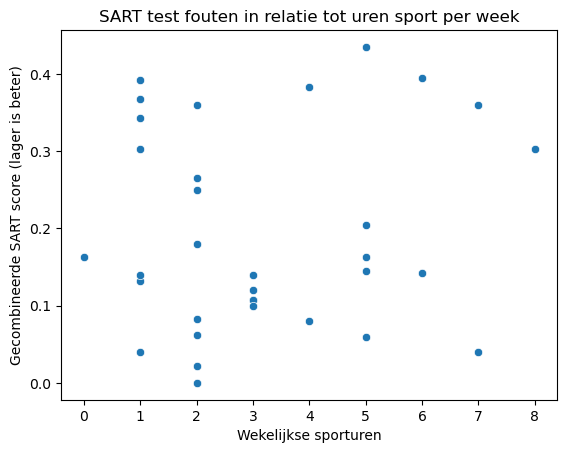

In [10]:
# Allereerst moeten we de outliers uit de data verwijderen. Dit doen we met behulp van de IQR methode
def remove_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    filtered_entries = ~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)
    return df[filtered_entries]

df_iqr_filtered = remove_outliers_iqr(data[['go_mistake_percentage', 'no_go_mistake_percentage', 'score', 'sport_uur_week']])
# display(df_iqr_filtered)
# display(data.head())

n = df_iqr_filtered.shape[0]  # Aantal waarnemingen

cor_no_go, p_no_go = stats.pearsonr(df_iqr_filtered['no_go_mistake_percentage'], df_iqr_filtered['sport_uur_week'])
cor_go, p_go = stats.pearsonr(df_iqr_filtered['go_mistake_percentage'], df_iqr_filtered['sport_uur_week'])

moe_no_go = margin_of_error(cor_no_go, n)
moe_go = margin_of_error(cor_go, n)

p_no_go_moe = margin_of_error(p_no_go, n)
p_go_moe = margin_of_error(p_go, n)

print(f"Pearson tussen no-go fouten en sport uren: {cor_no_go:.2f} ± {moe_no_go}, p-waarde: {p_no_go:.2f} ± {margin_of_error(p_no_go, n)}")
print(f"Pearson tussen go fouten en sport uren: {cor_go:.2f} ± {margin_of_error(cor_go, n)}, p-waarde: {p_go:.2f} ± {margin_of_error(p_go, n)}")

sns.scatterplot(x='sport_uur_week', y='score', data=df_iqr_filtered.sort_values('sport_uur_week'))
plt.title('SART test fouten in relatie tot uren sport per week')
plt.xlabel('Wekelijkse sporturen')
plt.ylabel('Gecombineerde SART score (lager is beter)')
plt.show()

In [11]:
data.to_csv('data_cognitie_chat.csv', index = False)
data.at[7, 'soort_sport'] = 'fitness, voetbal'
data.at[15, 'soort_sport'] = 'zwemmen, voetbal'
data.at[10, 'soort_sport'] = 'gym, cardio'
data.at[16, 'soort_sport'] = 'lopen, hardlopen'

for i in range(len(data)):
    if pd.notnull(data.at[i, 'soort_sport']):
        sport = str(data.at[i, 'soort_sport'])
        if ',' in sport and ', ' not in sport:
            data.at[i, 'soort_sport'] = sport.replace(',', ', ')


<bound method Series.unique of score           1.000000
interceptive   -0.070583
static         -0.051237
strategic       0.070417
no_sport        0.081128
Name: score, dtype: float64>


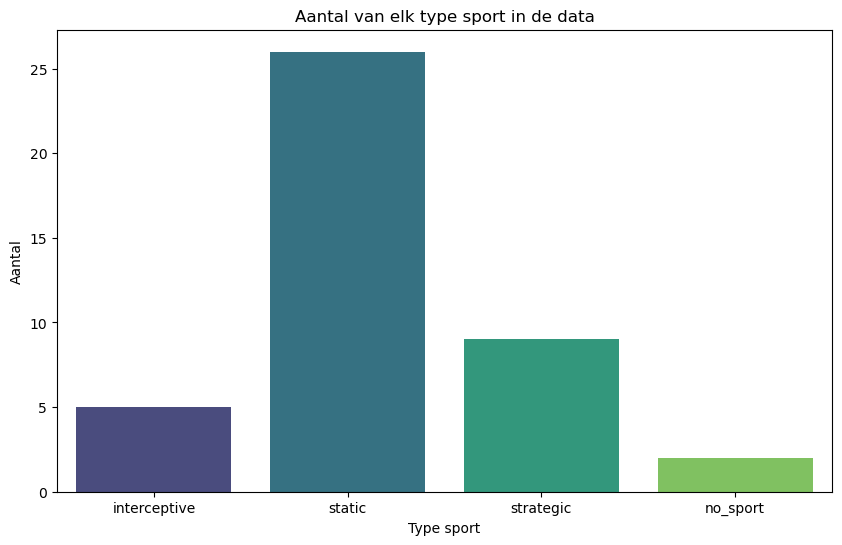

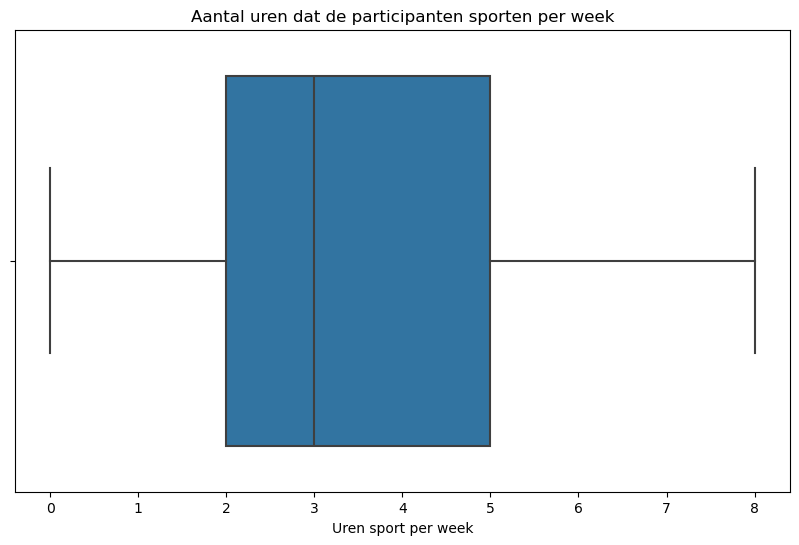

In [12]:
interceptive_sports = ["tennis", "fencing", "boxing", "table tennis", "free combat", "kickboksen", "karten", "boulderen", "squash", "mma", "roeien"]
static_sports = ["jogging", "gewichtstraining","swimming", "shooting", "lopen", "fitness", "wandelen", "mountainbiken", "hardlopen", "fietsen", "cardio", "gym", "pilates", "dans", "yoga","sportschool"]
strategic_sports = ["basketball", "soccer", "hockey", "rugby", "football", "basketbal", 'voetbal', "zaalvoetbal"]

# Function to classify sports into categories
def classify_sport(sport):
    categories = {'interceptive': 0, 'static': 0, 'strategic': 0}
    for s in sport.split(", "):
        s = s.lower()
        if s in interceptive_sports:
            categories['interceptive'] = 1
        if s in static_sports:
            categories['static'] = 1
        if s in strategic_sports:
            categories['strategic'] = 1
    return pd.Series(categories)

# Handle missing values in 'soort_sport' column
data['soort_sport'] = data['soort_sport'].fillna("")

# Apply classification to each row in the 'soort_sport' column
classification = data['soort_sport'].apply(classify_sport)
data = pd.concat([data, classification], axis=1)

# Calculate the median sport (most frequently done sport)
sport_counts = data['soort_sport'].str.lower().str.split(", ").explode().value_counts()
median_sport = sport_counts.idxmax()


data['soort_sport'] = data['soort_sport'].fillna("")

# Create a column for no sport participation
data['no_sport'] = data['soort_sport'].apply(lambda x: 1 if x.lower() in ['', 'geen'] else 0)

# One hot encoded columns already present (interceptive, static, strategic)
# Calculate counts for each sport type
sport_type_counts = data[['interceptive', 'static', 'strategic', 'no_sport']].sum()

# Create a bar plot for sport type counts
plt.figure(figsize=(10, 6))
sns.barplot(x=sport_type_counts.index, y=sport_type_counts.values, palette='viridis')
plt.title('Aantal van elk type sport in de data')
plt.xlabel('Type sport')
plt.ylabel('Aantal')
plt.savefig('sport_type_counts.png')

# Create a correlation matrix for score and different sport types
correlation_matrix = data[['score', 'interceptive', 'static', 'strategic', 'no_sport']].corr()
print(correlation_matrix['score'].unique)

# Create a boxplot for sport hours per week
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['sport_uur_week'])
plt.title('Aantal uren dat de participanten sporten per week')
plt.xlabel('Uren sport per week')
plt.savefig('sport_uur_week_boxplot.png')

In [13]:
data

,geslacht,amount_go,go_mistakes,amount_no_go,no_go_mistakes,sport_uur_week,soort_sport,studie,go_mistake_percentage,no_go_mistake_percentage,score,interceptive,static,strategic,no_sport
0,Man,200.0,6.0,25.0,19.0,6.0,"Fitness, Kickboksen",informatiekunde,0.030,0.76,0.3950,1,1,0,0
1,Man,200.0,0.0,25.0,18.0,7.0,Sportschool,informatiekunde,0.000,0.72,0.3600,0,1,0,0
2,Man,200.0,0.0,25.0,7.0,1.0,Karten,informatiekunde,0.000,0.28,0.1400,1,0,0,0
3,Man,200.0,1.0,25.0,19.0,4.0,Fitness,informatiekunde,0.005,0.76,0.3825,0,1,0,0
4,Vrouw,200.0,4.0,25.0,12.0,2.0,"Sportschool, fietsen, wandelen",informatiekunde,0.020,0.48,0.2500,0,1,0,0
5,Vrouw,200.0,1.0,25.0,7.0,6.0,Basketbal,informatiekunde,0.005,0.28,0.1425,0,0,1,0
6,Man,200.0,0.0,25.0,2.0,7.0,Fitness,informatiekunde,0.000,0.08,0.0400,0,1,0,0
7,Man,200.0,15.0,25.0,18.0,8.0,"fitness, voetbal",informatiekunde,0.075,0.72,0.3975,0,1,1,0
8,Man,200.0,5.0,25.0,19.0,1.0,atletiek,informatiekunde,0.025,0.76,0.3925,0,0,0,0
9,Vrouw,200.0,3.0,25.0,18.0,1.0,pilates,informatiekunde,0.015,0.72,0.3675,0,1,0,0


In [14]:
data.studie.unique()

array(['informatiekunde', 'Informatiekunde', 'WO Bachelor',
       'gezondheidswetenschappen', 'biologie bachelor', 'Social Work',
       'ICT', 'bedrijfskunde', 'Pedagogiek', 'User Experience Design',
       'Psychologie', 'pedagogiek', 'Economics and Business Economics'],
      dtype=object)

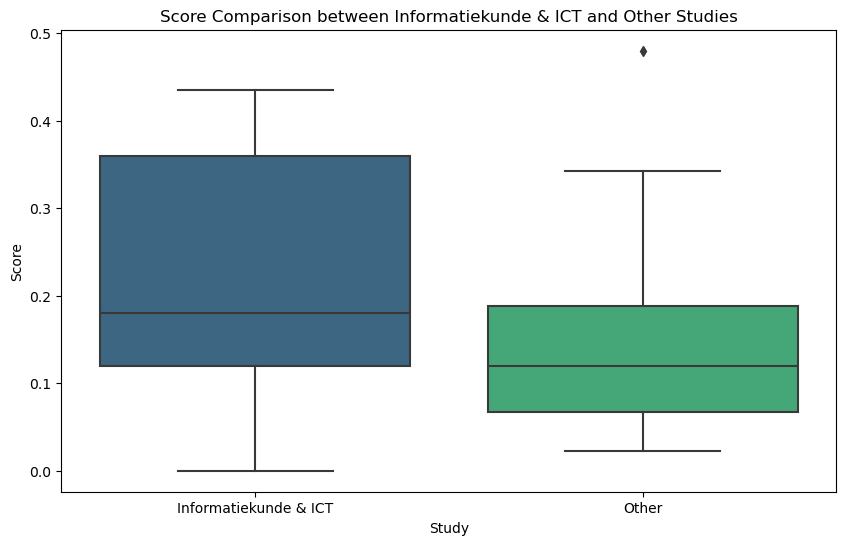

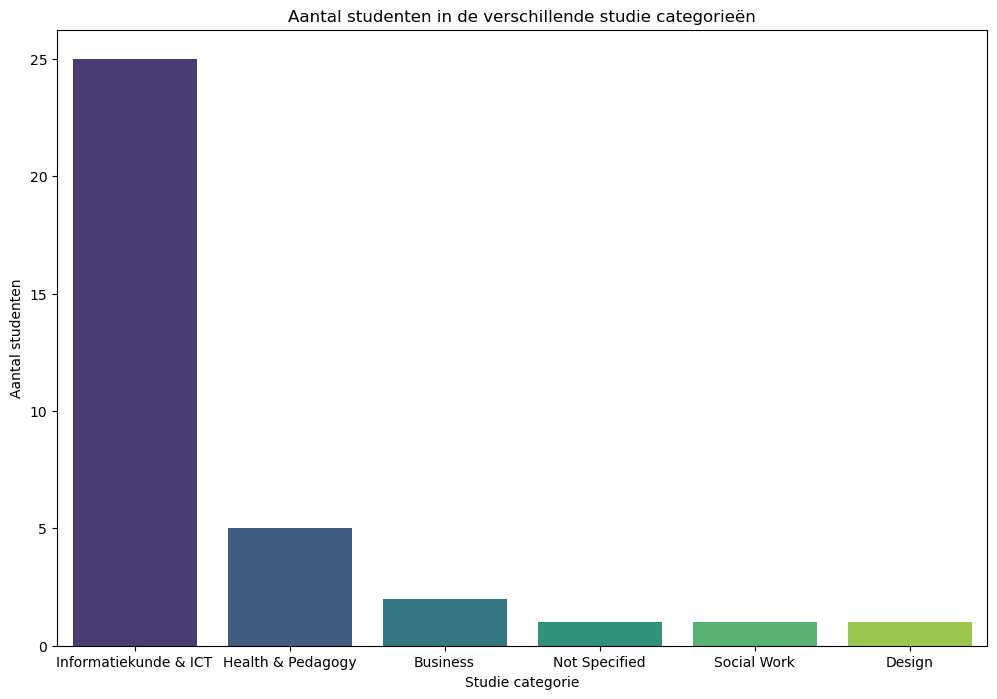

In [15]:
study_categories = {
    'Informatiekunde & ICT': ['informatiekunde', 'Informatiekunde', 'ICT'],
    'Health & Pedagogy': ['gezondheidswetenschappen', 'biologie bachelor', 'Pedagogiek', 'pedagogiek', 'Psychologie'],
    'Social Work': ['Social Work'],
    'Business': ['bedrijfskunde', 'Economics and Business Economics'],
    'Design': ['User Experience Design'],
    'Not Specified': ['WO Bachelor']
}

# Function to categorize studies
def categorize_study(study):
    for category, studies in study_categories.items():
        if any(s.lower() in study.lower() for s in studies):
            return category
    return 'Other'

# Apply categorization to the 'studie' column
data['study_category'] = data['studie'].apply(categorize_study)

# Combine Informatiekunde & ICT with the rest
data['is_informatiekunde_ict'] = data['study_category'].apply(lambda x: 'Informatiekunde & ICT' if x == 'Informatiekunde & ICT' else 'Other')

# Boxplot for score comparison
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_informatiekunde_ict', y='score', data=data, palette='viridis')
plt.title('Score Comparison between Informatiekunde & ICT and Other Studies')
plt.xlabel('Study')
plt.ylabel('Score')
plt.show()

# Bar plot for study categories
plt.figure(figsize=(12, 8))
sns.countplot(x='study_category', data=data, palette='viridis', order=data['study_category'].value_counts().index)
plt.title('Aantal studenten in de verschillende studie categorieën')
plt.xlabel('Studie categorie')
plt.ylabel('Aantal studenten')
plt.savefig('study_category_countplot.png')

In [16]:
import plotly.graph_objects as go


# Aantal mannen en vrouwen tellen
aantal_mannen = len(data[data['geslacht'] == 'Man'])
aantal_vrouwen = len(data[data['geslacht'] == 'Vrouw'])

# Data voor de chart
labels = ['Man', 'Vrouw']
values = [aantal_mannen, aantal_vrouwen]

# Kleuren voor de sectoren van het cirkeldiagram
colors = ['#4a90e2', '#ff6f61']

# Donut chart maken met Plotly
pie_trace = go.Pie(
    labels=labels,
    values=values,
    hole=0.8,
    textposition='outside',
    textinfo="label+percent",
    marker={'colors': colors}
)

pie_layout = go.Layout(
    # title='Verdeling van geslachten',
    showlegend=False,
    height=600,
    annotations=[dict(text='N = 35', x=0.5, y=0.5, font_size=20, showarrow=False)]
)

fig = go.Figure(
    data=[pie_trace],
    layout=pie_layout
)

fig.show()

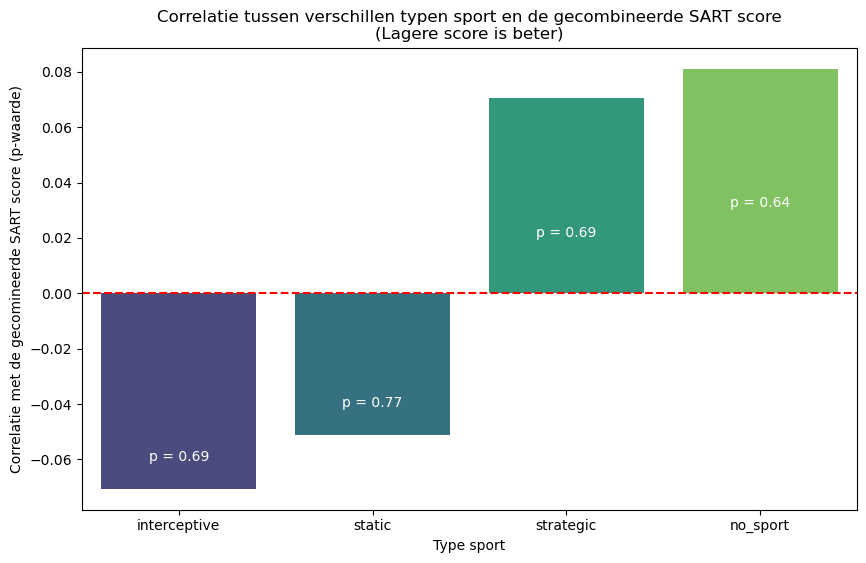

In [18]:
correlation_results = []
sport_types = ['interceptive', 'static', 'strategic', 'no_sport']

for sport_type in sport_types:
    correlation, p_value = pearsonr(data[sport_type], data['score'])
    correlation_results.append({'sport_type': sport_type, 'correlation': correlation, 'p_value': p_value})

# Converteer de resultaten naar een DataFrame
correlation_df = pd.DataFrame(correlation_results)

# Maak een staafdiagram
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='sport_type', y='correlation', data=correlation_df, palette='viridis')

# Voeg een rode stippellijn toe bij y=0
plt.axhline(0, color='red', linestyle='--')

# Voeg de p-waarden toe als annotaties binnen de balken
for index, row in correlation_df.iterrows():
    y_position = row['correlation'] - 0.05 if row['correlation'] > 0 else row['correlation'] + 0.01
    bar_plot.text(index, y_position, f'p = {row["p_value"]:.2f}', color='white', ha="center")

plt.title('Correlatie tussen verschillen typen sport en de gecombineerde SART score\n(Lagere score is beter)')
plt.xlabel('Type sport')
plt.ylabel('Correlatie met de gecomineerde SART score (p-waarde)')
plt.savefig('sport_type_correlation.png')

In [30]:
n_interceptive = sport_type_counts['interceptive']
n_static = sport_type_counts['static']
n_strategic = sport_type_counts['strategic']

display(correlation_df)
moe_interceptive = margin_of_error(0.687014, n_interceptive)
moe_static = margin_of_error(0.770053, n_static)
moe_strategic = margin_of_error(0.687713, n_strategic)

print(moe_interceptive, moe_static, moe_strategic)

,sport_type,correlation,p_value
0,interceptive,-0.070583,0.687014
1,static,-0.051237,0.770053
2,strategic,0.070417,0.687713
3,no_sport,0.081128,0.643156


0.29 0.12 0.24
